# Toy Example

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

## Import Packages

In [2]:
# Data
# from survae.data.datasets.toy import TwoMoonsDataset, SineWaveDataset, CheckerboardDataset
from torch.utils.data import DataLoader, Dataset# Model
import torch
import torch.nn as nn
from survae.flows import Flow
from survae.distributions import StandardNormal

from pytorch_lightning.callbacks import TQDMProgressBar
# Optim
from torch.optim import Adam

# Plot
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from survae.datasets.toy.plane import TwoMoonsDataset

In [4]:
n_train = 10_000
n_valid = 1_000
n_test = 100_000

ds_train = TwoMoonsDataset(num_points=n_train, noise=0.05, seed=123)
ds_valid = TwoMoonsDataset(num_points=n_valid, noise=0.05, seed=42)
ds_test = TwoMoonsDataset(num_points=n_test, noise=0.05, seed=666)


dl_train = DataLoader(ds_train, batch_size=128, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=128, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=1_000, shuffle=False)

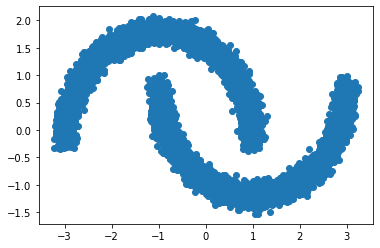

In [5]:
fig, ax = plt.subplots()

ax.scatter(ds_train[:][:, 0], ds_train[:][:, 1])
plt.show()

## Model

$$
\begin{aligned}
x_A, x_B &= \text{Split}(x) \\
z_A &= x_A \\
z_B &= x_B + \boldsymbol{f}(\mathbf{x}_A) \\
z &= \text{Concat}(z_A, z_B)
\end{aligned}
$$

In [6]:
from survae.transforms import Bijection

In [7]:
import torch.nn as nn
from survae.flows import Flow
from survae.distributions import StandardNormal
from survae.transforms import AffineCouplingBijection, ActNormBijection, BatchNormBijection, Reverse
from survae.transforms import AdditiveCouplingBijection
from survae.transforms import RationalQuadraticSplineCouplingBijection
from survae.nn.layers import ElementwiseParams


# # NICE Model
# def net():
#     return nn.Sequential(nn.Linear(1, 128), nn.ReLU(),
#                        nn.Linear(128, 1), ElementwiseParams(1))

# model = Flow(
#     base_dist=StandardNormal((2,)),
#     transforms=[
#         AdditiveCouplingBijection(net()), ActNormBijection(2), Reverse(2),
#         AdditiveCouplingBijection(net()), ActNormBijection(2), Reverse(2),
#         AdditiveCouplingBijection(net()), ActNormBijection(2), Reverse(2),
#         AdditiveCouplingBijection(net()), ActNormBijection(2), Reverse(2),
#         AdditiveCouplingBijection(net()), ActNormBijection(2), Reverse(2),
#         AdditiveCouplingBijection(net()), ActNormBijection(2),
#     ])


# RealNVP Model
def net():
    return nn.Sequential(nn.Linear(1, 128), nn.ReLU(),
                       nn.Linear(128, 2), ElementwiseParams(2))

model = Flow(
    base_dist=StandardNormal((2,)),
    transforms=[
        AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
        AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
        AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
        AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
        AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
        AffineCouplingBijection(net()), ActNormBijection(2),
    ])

### Demo Data

In [8]:
x_init = ds_train[:1_000]

loss = model.log_prob(x_init)


In [9]:
z, ldj = model.forward_transform(x_init)
x_approx = model.inverse_transform(z)



In [10]:
# torch.testing.assert_allclose(test_x, x_approx)

In [11]:
import corner

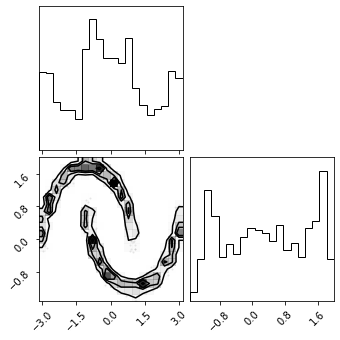

In [12]:
fig = corner.corner(x_init.detach().numpy())

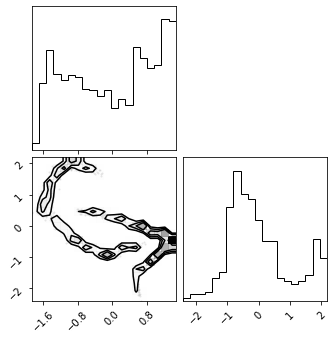

In [13]:
fig = corner.corner(z.detach().numpy())

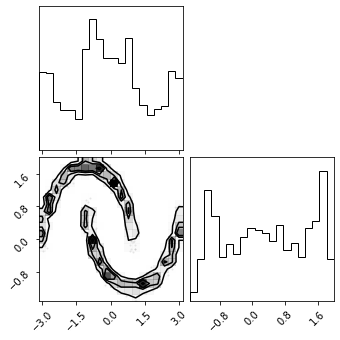

In [14]:
fig = corner.corner(x_approx.detach().numpy())

## Trainer

In [15]:
import pytorch_lightning as pl
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR

class Learner2DPlane(pl.LightningModule):
    def __init__(self, model:nn.Module, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        # self.hyperparams = cast(Dict[str, Any], self.hparams)
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
                
        # loss function
        loss = -self.model.log_prob(batch).mean()
        
        self.log("loss", loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
                
        # loss function
        loss = -self.model.log_prob(batch).mean()
        
        self.log("val_loss", loss)
        
        return loss
    
    def test_step(self, batch, batch_idx):
                
        # loss function
        loss = -self.model.log_prob(batch).mean()
        
        self.log("test_loss", loss)
        
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.model.parameters(), lr=self.hparams.get("lr", 1e-4))

        scheduler = LinearWarmupCosineAnnealingLR(
            optimizer,
            warmup_epochs=self.hparams.get("warmup", 10),
            max_epochs=self.hparams.get("num_epochs", 300),
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

In [16]:
learning_rate = 1e-3
num_epochs = 500
warmup = 50
# initialize trainer
learn = Learner2DPlane(
    model,
    num_epochs=num_epochs,
    warmup=warmup,
    lr=learning_rate,
)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [17]:
n_epochs = 500

callbacks = [TQDMProgressBar(refresh_rate=5)]

# initialize trainer
trainer = pl.Trainer(
    min_epochs=1,
    max_epochs=num_epochs,
    accelerator="mps",
    # devices=1,
    enable_progress_bar=True,
    # logger=wandb_logger,
    callbacks=callbacks,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(
    learn,
    train_dataloaders=dl_train,
    val_dataloaders=dl_valid
)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:107: UserWarning: attribute 'model' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")

  | Name  | Type | Params
-------------------------------
0 | model | Flow | 3.1 K 
-------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [25]:
results = trainer.test(learn, dataloaders=dl_test)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       400981.84375        │
└───────────────────────────┴───────────────────────────┘

## Latent Space

In [26]:
z_latent, ldj = learn.model.forward_transform(ds_valid[:])

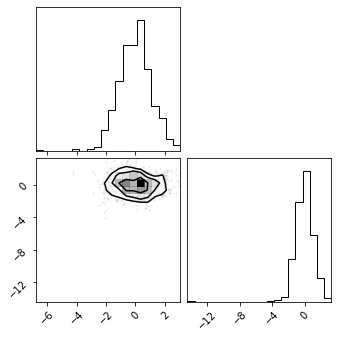

In [27]:
fig = corner.corner(z_latent.detach().numpy())

### Likelihood

## Sampling

In [28]:
%%time
print('Sampling...')

samples = learn.model.sample(10_000).detach().numpy()

Sampling...
CPU times: user 10.9 ms, sys: 14.2 ms, total: 25.1 ms
Wall time: 10.4 ms


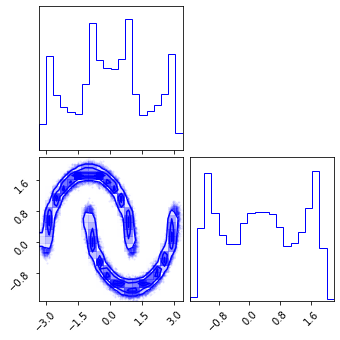

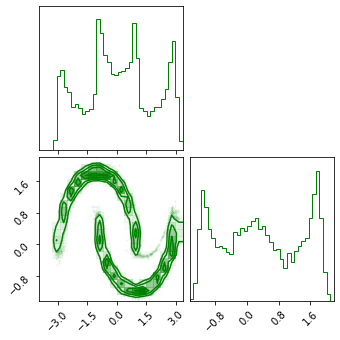

In [29]:
data = ds_test[:].detach().numpy()

fig = corner.corner(data, color="blue")


fig = corner.corner(samples, color="green", hist_bin_factor=2, )

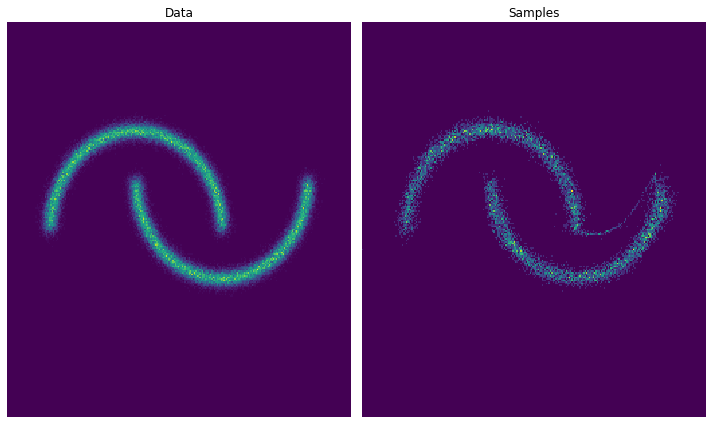

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].set_title('Data')
ax[0].hist2d(data[...,0], data[...,1], bins=256, range=[[-4, 4], [-4, 4]])
ax[0].set_xlim([-4, 4]); ax[0].set_ylim([-4, 4]); ax[0].axis('off')
ax[1].set_title('Samples')
ax[1].hist2d(samples[...,0], samples[...,1], bins=256, range=[[-4, 4], [-4, 4]])
ax[1].set_xlim([-4, 4]); ax[1].set_ylim([-4, 4]); ax[1].axis('off')
plt.tight_layout()
plt.show()

